In [3]:
import talib

import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

## DEFINING INDICATORS
This is a list of indicators provided by TA-Lib to develop your trading strategies.

Indicators [EMA(10 and 20), CCI(20),  MACD(12, 26, 9)]


# TRADING STRATEGY
In this trading strategy, we define entry and exit conditions based on the selected indicators. The conditions are as follows:

### Buy signal 

 - Entry Condition:
       - Condition 1: Check if 10-period EMA crosses above 20-period EMA.
       - Condition 2: Check if CCI crosses the +100 line.
       - Condition 3: Check if the MACD line crosses above the zero line.

 - Exit Condition:
       - Condition 1: Check if CCI crosses the -100 line.

### Sell signal 

 - Entry Condition:
       - Condition 1: Check if 10-period EMA crosses below 20-period EMA.
       - Condition 2: Check if CCI crosses the -100 line.
       - Condition 3: Check if the MACD line crosses below the zero line.

 - Exit Condition:
       - Condition 1: Check if CCI crosses the +100 line.


    
    
### Generating Signals:

   - A DataFrame named signals is created to store the buy/sell signals.
   - The 'positions' column is initialized with zeros (no position).
   - The entry_condition is used to set the 'positions' value to 1 (buy signal) where the conditions are met.
   - The exit_condition is used to set the 'positions' value to -1 (sell signal) where the condition is met.

In [66]:
# Define your trading strategy
def strategy(data):
    # Define the entry and exit conditions for buy signal
    condition1_buy = data['EMA_10'] > data['EMA_20']
    condition2_buy = data['MACD_HIST'] > 0

    entry_condition_buy = condition1_buy & condition2_buy
    exit_condition_buy = data['MACD_HIST'] < 0

    # Define the entry and exit conditions for sell signal
    condition1_sell = data['EMA_10'] < data['EMA_20']
    condition2_sell = data['MACD_HIST'] < 0

    entry_condition_sell = condition1_sell & condition2_sell 
    exit_condition_sell = data['MACD_HIST'] < 0

    # Generate the signals
    signals = pd.DataFrame(index=data.index)
    signals['positions'] = 0
    signals.loc[entry_condition_buy, 'positions'] = 1
    signals.loc[exit_condition_buy, 'positions'] = -1
    signals.loc[entry_condition_sell, 'positions'] = -1
    signals.loc[exit_condition_sell, 'positions'] = 1

    return signals


## HISTORICAL DATA
Next, we download historical stock data for the specified symbol (in this case, 'AAPL' for Apple Inc.) from the start date to the end date using the yfinance library.

In [56]:
symbol = 'SPY'
start_date = '2020-01-01'
end_date = '2023-01-01'

data = yf.download(symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [57]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,307.375671,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,305.048157,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,306.211914,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,305.350952,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,306.978302,68296000


## CALCULATING INDICATORS


In [58]:
# Calculate the indicators

data['EMA_10'] = talib.EMA(data['Close'], timeperiod=10)
data['EMA_20'] = talib.EMA(data['Close'], timeperiod=20)

# Calculate MACD
macd, macd_signal, macd_hist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Extract MACD Histogram
macd_hist = macd_hist * 2  # Multiply by 2 to match the conventional MACD histogram scaling

data['MACD_HIST'] = macd_hist

In [59]:
data.sample(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_20,MACD_HIST
Date,,,,,,,,,
2020-02-24,323.140015,333.559998,321.239990,322.420013,305.057587,161088400,332.854323,332.092069,-1.214145
2022-06-30,376.239990,380.660004,372.559998,377.250000,371.188568,112508300,381.360169,386.188211,1.461398
2022-10-03,361.079987,368.549988,359.209991,366.609985,362.201263,89756500,369.817169,379.018907,-3.382012
2021-06-24,424.890015,425.549988,424.619995,425.100006,412.406158,45110300,422.266684,421.188639,-0.374870
2020-10-26,342.130005,342.980011,335.619995,339.390015,325.722137,91473000,343.492035,342.260538,-0.938448


## STRATEGY AND BACKTESTING
This section applies the trading strategy to the data and backtests it. It generates buy/sell signals based on the strategy's entry and exit conditions. Then, it calculates the portfolio by taking the difference of positions (signals_1['positions'].diff()) and initializes the first position. It also calculates the returns, strategy returns (returns multiplied by portfolio), and cumulative returns. Finally, it prints the cumulative returns and plots them.

In [60]:
signals_1 = strategy(data) 

In [61]:
signals_1[(signals_1['positions'] == 1) ]#| (signals_1['positions']==-1)]

,positions
Date,
2020-02-20,1
2020-02-21,1
2020-02-24,1
2020-02-25,1
2020-02-26,1
...,...
2022-12-23,1
2022-12-27,1
2022-12-28,1


## SIGNAL RETURNS  BUY POSITIONS ONLY?

In [62]:
portfolio = signals_1['positions'].diff()

portfolio.iloc[0] = signals_1['positions'].iloc[0]

data['portfolio'] = portfolio

data['returns'] = data['Close'].pct_change()
data['strategy_returns'] = data['returns']*data['portfolio']

data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()
data['cumulative_returns'] = (1 + data['returns']).cumprod()


Text(0, 0.5, 'Cumulative Returns')

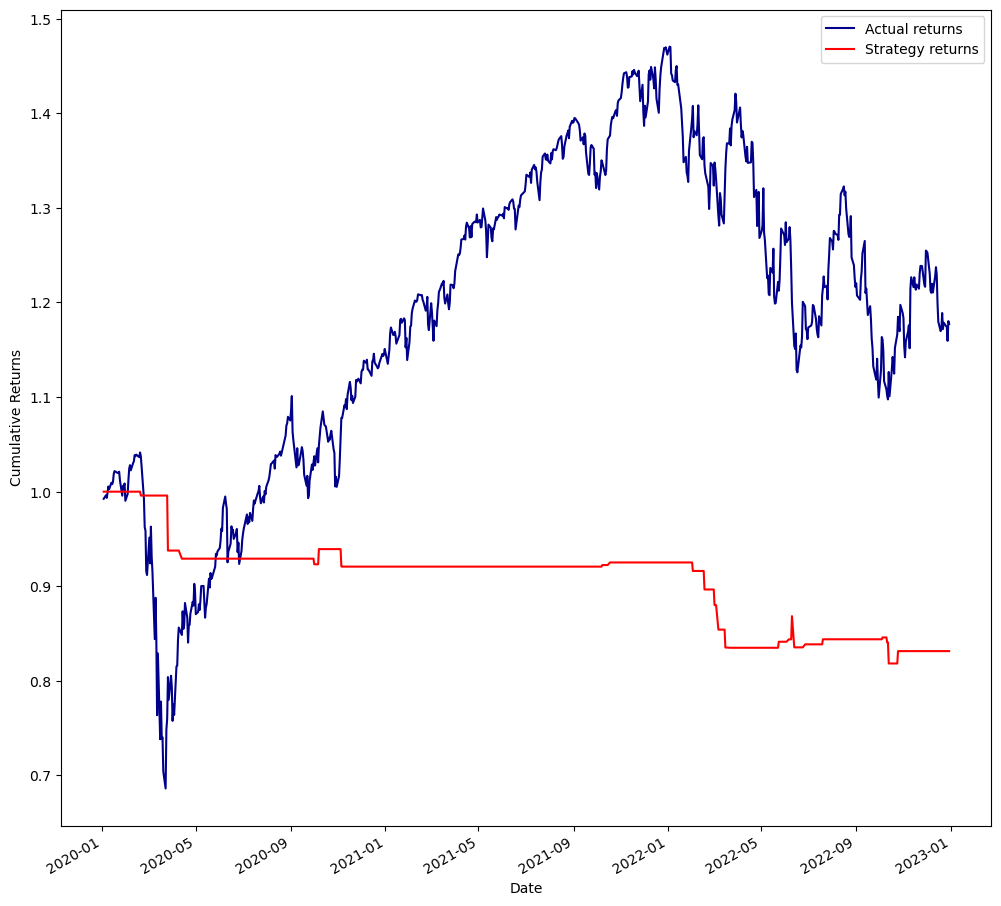

In [65]:
plt.figure(figsize=(12,12))
data['cumulative_returns'].plot(label = 'Actual returns', color='darkblue')
data['cumulative_strategy_returns'].plot(label = 'Strategy returns', color='red')
plt.legend()
plt.ylabel('Cumulative Returns')

In [64]:
standard_dev_strat= (data['Close'].std())
returns_strat = 1.6 - 1.0/1.0

print(standard_dev)
print(returns)

NameError: name 'standard_dev' is not defined

In [24]:
standard_dev_cum= (data['Close'].std())
returns_cum = 1.2 - 1.0/1.0

print(standard_dev)
print(returns)

54.922197078909775
0.19999999999999996


In [34]:
sharpe_cum = returns_cum/standard_dev_cum

print(sharpe_cum)

0.003641514918142274


In [35]:
sharpe_strat = returns_strat/standard_dev_strat

print(sharpe_strat)

0.010924544754426824


In [36]:
plt.figure(figsize=(12,12))
sharpe_cum.plot(label = 'Sharpe', color='darkblue')
sharpe_strat.plot(label = 'Sharpe', color='red')
plt.legend()
plt.ylabel('Sharp[e ratio]')

AttributeError: 'float' object has no attribute 'plot'

<Figure size 1200x1200 with 0 Axes>